In [1]:
import sqlite3
import pandas as pd
import gensim
import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn.cluster import KMeans

In [10]:
from sklearn import metrics

In [15]:
cx = sqlite3.connect('/home/wsyj/dissertation__imdb/005_scrapy_hello/tutorial/tutorial/spiders/my_db.db')

In [9]:
# load word2vec model
model_path = '/home/wsyj/dissertation__recommendation_system__experiment_2/dissertation__recommendation_system__experiment/main_modelnum_features=200_min_count=5_window=2.model'
model = gensim.models.Word2Vec.load(model_path)


In [16]:
cur.execute('select distinct(item_id) from items_with_synopsis')
r = cur.fetchall()
r = [x[0] for x in r]

In [34]:
vec_list = []
for item in r:
    key = str(item)
    if key not in model:
        continue
    vec_list.append(model[key])
data = np.array(vec_list    )

In [4]:
# get all genres
cur = cx.cursor()

cur.execute('select genres from genres_of_items_with_synopsis')

ret = cur.fetchall()
len(ret)
#442
ret = [x[0] for x in ret]
len(ret)
#442
ret[0]
ret = ','.join(ret)
ret = ret.split(',')
len(ret)
#1300
len(set(ret))
#21
all_genres = set(ret)
all_genres = list(all_genres)
all_genres.sort()

In [5]:
print all_genres

[u'Action', u'Adventure', u'Animation', u'Biography', u'Comedy', u'Crime', u'Drama', u'Family', u'Fantasy', u'Film-Noir', u'History', u'Horror', u'Music', u'Musical', u'Mystery', u'Romance', u'Sci-Fi', u'Sport', u'Thriller', u'War', u'Western']


In [36]:
# find out genres of items in a cluster
def find_out_genres_of_items_in_a_cluster(cluster_label, y_pred, model):
    c = data[y_pred == cluster_label]
    
    item_genre_list = []
    for member in c:
        item_id, simi = model.most_similar([member], topn=1)[0]
        assert(simi > 0.99999)
        
        cur.execute('select genres from genres_of_items_with_synopsis where item_id = %s' % item_id)
        ret = cur.fetchall()
        ret = [x[0] for x in ret]
        assert(1 == len(ret))
        
        item_genre_list.append((item_id, ret))
    return item_genre_list



In [7]:
# find out genre distribution
def find_genre_dist(item_genre_list):
    dist_dist = reduce(lambda x, y: (None, x[1] + y[1]), item_genre_list)
    dist_dist = dist_dist[1]
    dist_dist = [x.split(',') for x in dist_dist]
    dist_dist = reduce(lambda x, y: x + y, dist_dist)
    
    genre_set = set(dist_dist)
    genre_unique_list = list(genre_set)
    
    dist = [(x, list(dist_dist).count(x)) for x in genre_unique_list]
    dist.sort(key=lambda x: -1 * x[1])
    
    return dist

In [8]:
def bench_k_means(estimator, name, data, sample_size=300):
    t0 = time()
    estimator.fit(data)

    print('% 9s   %.2fs    %.3f'
          % (name, (time() - t0), 
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)
))
    
    y_pred = estimator.predict(data)
    return y_pred

In [19]:
pred_result_map = {}
score_map = {}
prm = pred_result_map
sample_size = 300
for n_digits in range(2, 15):
    name = 'k-means++'
    t0 = time()
    estimator = KMeans(init=name, n_clusters=n_digits, n_init=100)
    estimator.fit(data)
    
    silhouette_score = metrics.silhouette_score(data, estimator.labels_, metric='euclidean', sample_size=sample_size)
    print('n_digits=%d   % 9s   %.2fs    %.3f' % (n_digits, name, (time() - t0), silhouette_score))
    prm[n_digits] = estimator.labels_
    score_map[n_digits] = silhouette_score


n_digits=2   k-means++   0.38s    0.159
n_digits=3   k-means++   0.56s    0.142
n_digits=4   k-means++   0.62s    0.132
n_digits=5   k-means++   0.75s    0.143
n_digits=6   k-means++   0.82s    0.134
n_digits=7   k-means++   0.86s    0.113
n_digits=8   k-means++   0.95s    0.042
n_digits=9   k-means++   1.05s    0.062
n_digits=10   k-means++   1.09s    0.017
n_digits=11   k-means++   1.08s    0.079
n_digits=12   k-means++   1.09s    0.074
n_digits=13   k-means++   1.19s    0.029
n_digits=14   k-means++   1.27s    -0.000


In [23]:
0

0

In [26]:
len(data)

420

In [27]:
len(prm[2])

420

In [32]:
np.arange(5)

array([0, 1, 2, 3, 4])

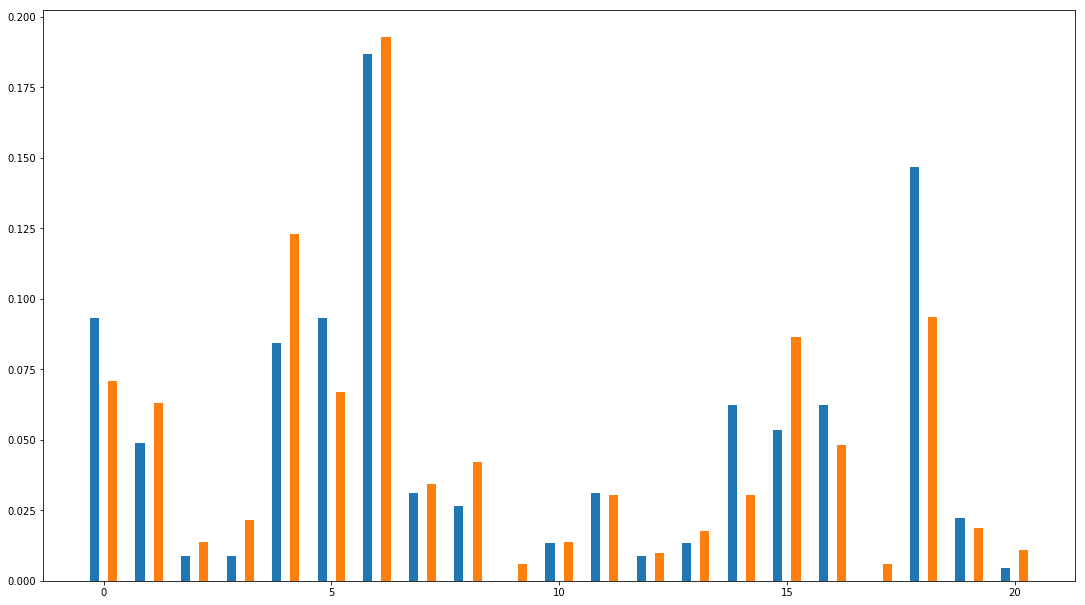

In [42]:
igl_0 = find_out_genres_of_items_in_a_cluster(0, prm[2], model) 
igl_1 = find_out_genres_of_items_in_a_cluster(1, prm[2], model)

gd0 = find_genre_dist(igl_0)
gd1 = find_genre_dist(igl_1)
d0 = dict(gd0)
d1 = dict(gd1)

for g in all_genres:
        if g not in d0:
            d0[g] = 0
for g in all_genres:
        if g not in d1:
            d1[g] = 0
assert(set(d0.keys()) == set(d1.keys()))

d0_list = [d0[x] for x in all_genres]
d1_list = [d1[x] for x in all_genres]

d0_list_copy = d0_list[:]
d0_list = np.array(d0_list) * 1. / sum(d0_list)

d1_list_copy = d1_list[:]
d1_list = np.array(d1_list) * 1. / sum(d1_list)

indexes = np.arange(len(all_genres))

plt.bar(indexes - 0.2, d0_list, 0.2)
plt.bar(indexes + 0.2, d1_list, 0.2)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)

plt.show()

In [46]:
np.random.rand(10, 4)

array([[ 0.99321386,  0.75671044,  0.30852014,  0.88138383],
       [ 0.9018056 ,  0.83133961,  0.85739764,  0.11274636],
       [ 0.17011929,  0.04722505,  0.32742641,  0.09792062],
       [ 0.8520923 ,  0.59405983,  0.25410066,  0.60249242],
       [ 0.89672469,  0.75811936,  0.56734156,  0.4017995 ],
       [ 0.71067348,  0.65310533,  0.91731789,  0.75193156],
       [ 0.40863394,  0.99321166,  0.15616005,  0.7209536 ],
       [ 0.58074293,  0.60950924,  0.05539113,  0.87947365],
       [ 0.82367301,  0.72787372,  0.72459668,  0.69413191],
       [ 0.88005554,  0.35739363,  0.7782555 ,  0.03277105]])

In [51]:
print d0_list
print d1_list

tmp = zip(d0_list, d1_list)
print tmp

[ 0.09333333  0.04888889  0.00888889  0.00888889  0.08444444  0.09333333
  0.18666667  0.03111111  0.02666667  0.          0.01333333  0.03111111
  0.00888889  0.01333333  0.06222222  0.05333333  0.06222222  0.
  0.14666667  0.02222222  0.00444444]
[ 0.07079646  0.06293019  0.01376598  0.02163225  0.12291052  0.06686332
  0.1927237   0.03441495  0.04228122  0.00589971  0.01376598  0.03048181
  0.00983284  0.01769912  0.03048181  0.08652901  0.04818092  0.00589971
  0.093412    0.0186824   0.01081613]
[(0.093333333333333338, 0.070796460176991149), (0.048888888888888891, 0.062930186823992137), (0.0088888888888888889, 0.01376597836774828), (0.0088888888888888889, 0.021632251720747297), (0.084444444444444447, 0.12291052114060963), (0.093333333333333338, 0.066863323500491637), (0.18666666666666668, 0.1927236971484759), (0.03111111111111111, 0.0344149459193707), (0.026666666666666668, 0.042281219272369712), (0.0, 0.0058997050147492625), (0.013333333333333334, 0.01376597836774828), (0.0311111

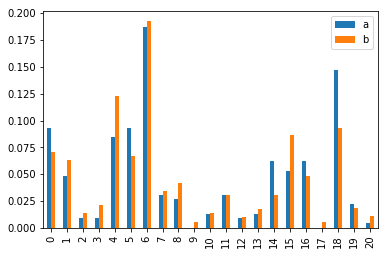

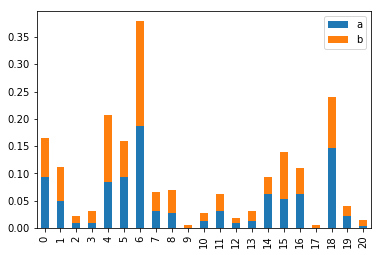

In [53]:

df2 = pd.DataFrame(tmp, columns=['a', 'b'])

df2.plot.bar()
    
df2.plot.bar(stacked=True)

plt.show()

In [ ]:
5

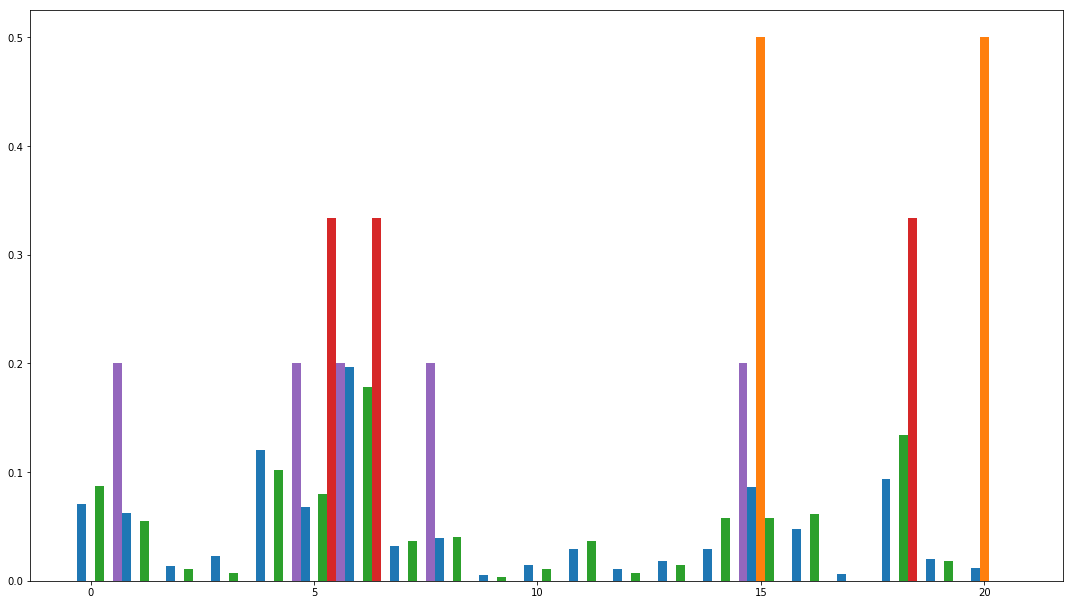

In [67]:

interested_k = 5

item_genres_list__list = [find_out_genres_of_items_in_a_cluster(x, prm[interested_k], model) for x in xrange(interested_k)]

genre_dist_list = [find_genre_dist(igl) for igl in item_genres_list__list]

d_dict_list = [dict(gd) for gd in genre_dist_list]

for d in d_dict_list:
    for g in all_genres:
        if g not in d:
            d[g] = 0
for i in xrange(len(d_dict_list)):
    for j in xrange(i):
        assert(set(d_dict_list[i].keys()) == set(d_dict_list[j].keys()))

d_list_list = [[d[x] for x in all_genres] for d in d_dict_list]


d_list_list = [np.array(d_list) * 1. / sum(d_list) for d_list in d_list_list]


indexes = np.arange(len(all_genres))

for i, d_list in enumerate(d_list_list):
    plt.bar(indexes - 0.2 + 0.2 * i, d_list, 0.2)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)

plt.show()


In [73]:
all_genres

[u'Action',
 u'Adventure',
 u'Animation',
 u'Biography',
 u'Comedy',
 u'Crime',
 u'Drama',
 u'Family',
 u'Fantasy',
 u'Film-Noir',
 u'History',
 u'Horror',
 u'Music',
 u'Musical',
 u'Mystery',
 u'Romance',
 u'Sci-Fi',
 u'Sport',
 u'Thriller',
 u'War',
 u'Western']

[(0.071055381400208992, 0.0, 0.08727272727272728, 0.0, 0.20000000000000001), (0.062695924764890276, 0.0, 0.054545454545454543, 0.0, 0.0), (0.013584117032392894, 0.0, 0.01090909090909091, 0.0, 0.0), (0.022988505747126436, 0.0, 0.0072727272727272727, 0.0, 0.0), (0.12016718913270637, 0.0, 0.10181818181818182, 0.0, 0.20000000000000001), (0.067920585161964475, 0.0, 0.080000000000000002, 0.33333333333333331, 0.20000000000000001), (0.19644723092998956, 0.0, 0.17818181818181819, 0.33333333333333331, 0.0), (0.032392894461859979, 0.0, 0.036363636363636362, 0.0, 0.20000000000000001), (0.039707419017763847, 0.0, 0.040000000000000001, 0.0, 0.0), (0.0052246603970741903, 0.0, 0.0036363636363636364, 0.0, 0.0), (0.014629049111807733, 0.0, 0.01090909090909091, 0.0, 0.0), (0.029258098223615466, 0.0, 0.036363636363636362, 0.0, 0.0), (0.010449320794148381, 0.0, 0.0072727272727272727, 0.0, 0.0), (0.017763845350052248, 0.0, 0.014545454545454545, 0.0, 0.0), (0.029258098223615466, 0.0, 0.058181818181818182, 0.

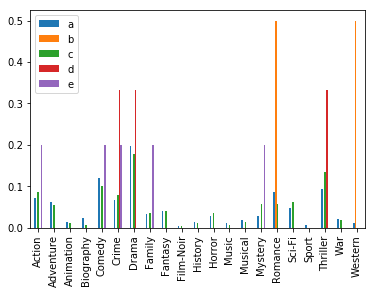

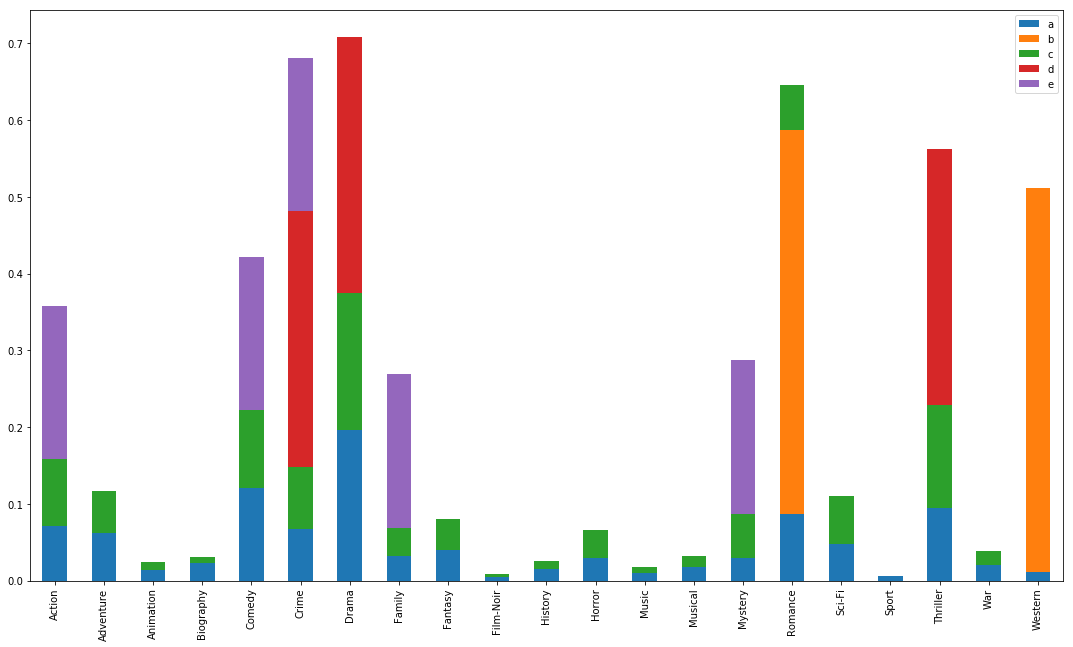

In [75]:

tmp = zip(*d_list_list)
print tmp


#ix2 = pd.MultiIndex.from_arrays([[chr(97 + x) for x in xrange(21)]])
ix2 = all_genres


df2 = pd.DataFrame(tmp, columns=[chr(97 + x) for x in xrange(len(d_list_list))], index=ix2)

df2.plot.bar()
    
df2.plot.bar(stacked=True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.show()


In [63]:
l1 = [1, 4, 7]
l2 = [2, 5, 8]
l3 = [3, 6, 9]
zip(l1, l2, l3)
zip(zip(l1, l2), l3)
zip(*[l1, l2, l3])

[(1, 2, 3), (4, 5, 6), (7, 8, 9)]